In [7]:
# Importing the libraries
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Specify training data directory
XRay_Directory = 'Dataset'

In [31]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [33]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [35]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [37]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 104 images belonging to 4 classes.


In [39]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [41]:
train_images.shape

(40, 256, 256, 3)

In [43]:
train_labels.shape

(40, 4)

In [45]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]],

In [47]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

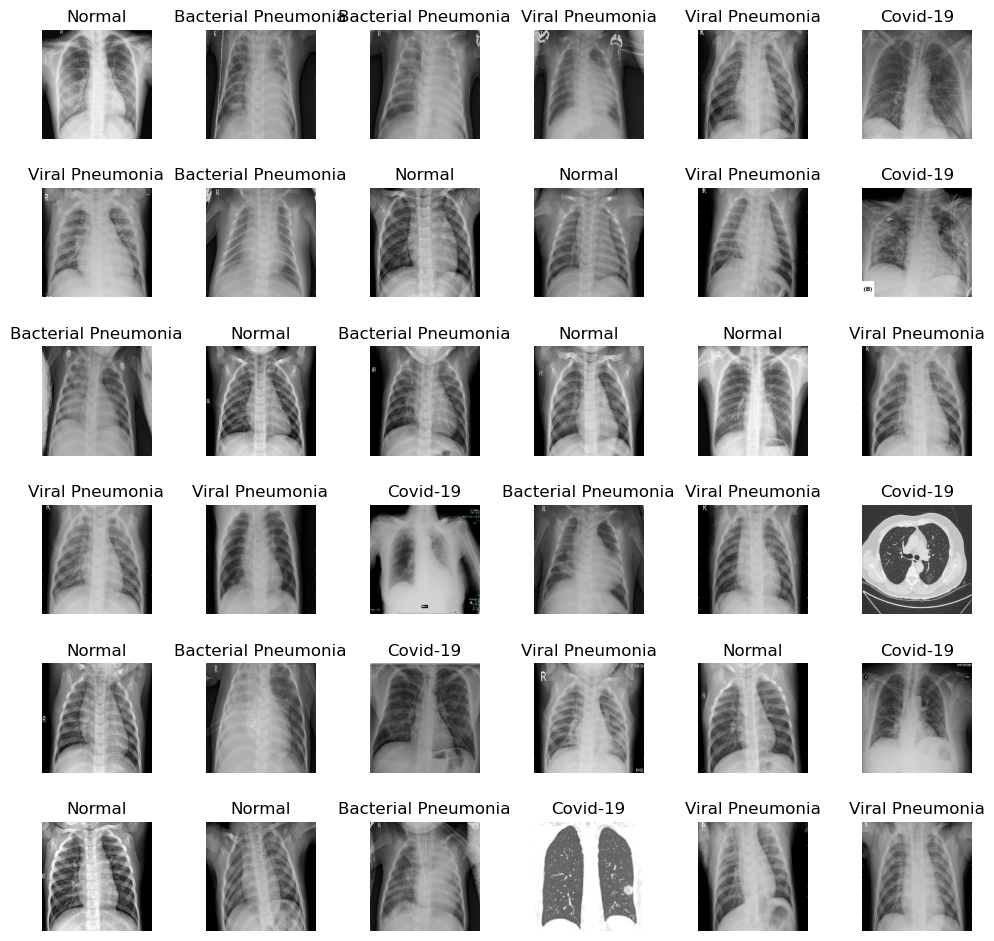

In [49]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

In [51]:
# Import model with pretrained weights
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [53]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [55]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [57]:
# Build and train deep learning model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [61]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [69]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

In [71]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [73]:
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [77]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

C:\Users\Mandar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


C:\Users\Mandar\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.5554 - loss: 1.2324
Epoch 1: val_loss improved from inf to 9.41481, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5563 - loss: 1.2292 - val_accuracy: 0.2500 - val_loss: 9.4148
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.8288 - loss: 0.4187
Epoch 2: val_loss did not improve from 9.41481
107/107 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8290 - loss: 0.4190 - val_accuracy: 0.2500 - val_loss: 16.7571
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.9031 - loss: 0.3178
Epoch 3: val_loss did not improve from 9.41481
107/107 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9030 - loss: 0.3179 - val_accuracy: 0.2500 - val_loss: 19.0640
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9355 - loss: 0.1679
Epoch 4: val_loss improved from 9.41481 to 3.03093, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accur

In [79]:
# Evalute trained deep learning model
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

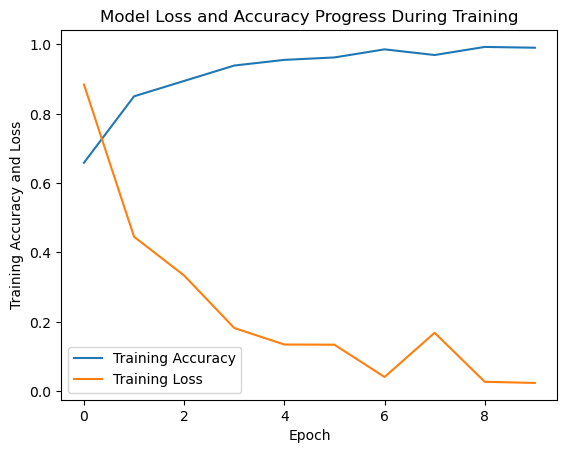

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

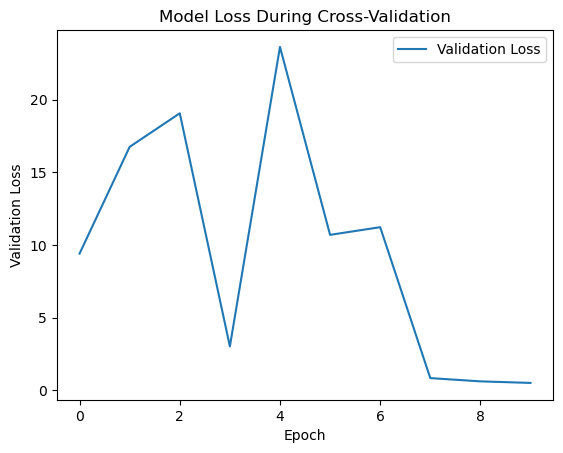

In [85]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

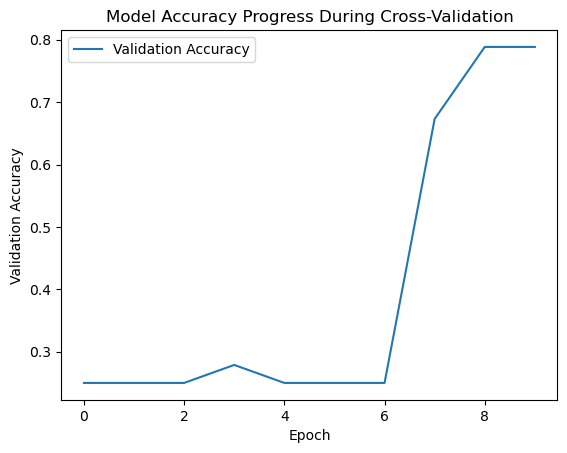

In [87]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [89]:
test_directory = 'D:\\Data Science - Real World Case Studies\\Operations Department\\Test'

In [93]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7250 - loss: 1.0874
Accuracy Test : 0.7250000238418579


In [95]:
# Evaluating the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [97]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [99]:
len(original)

40

In [101]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.75


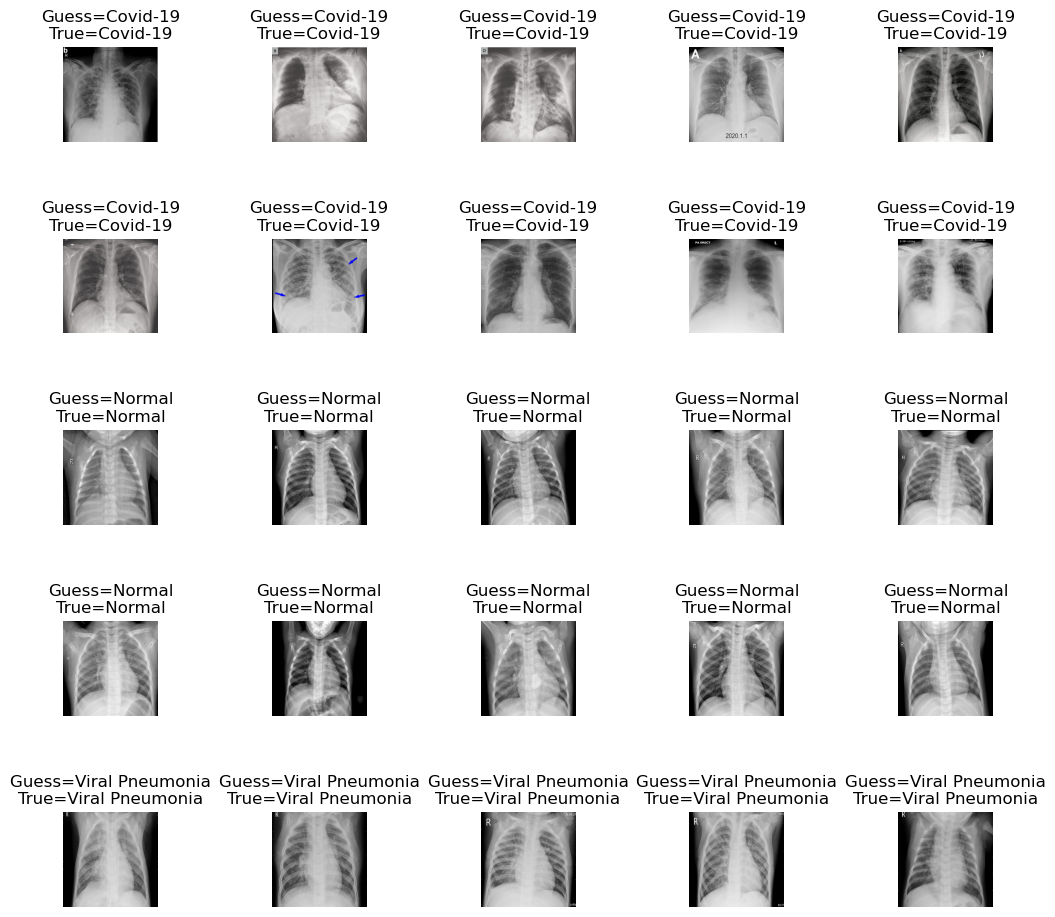

In [103]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [105]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.71      1.00      0.83        10
           2       0.71      0.50      0.59        10
           3       1.00      0.50      0.67        10

    accuracy                           0.75        40
   macro avg       0.79      0.75      0.73        40
weighted avg       0.79      0.75      0.73        40



Text(0.5, 1.0, 'Confusion_matrix')

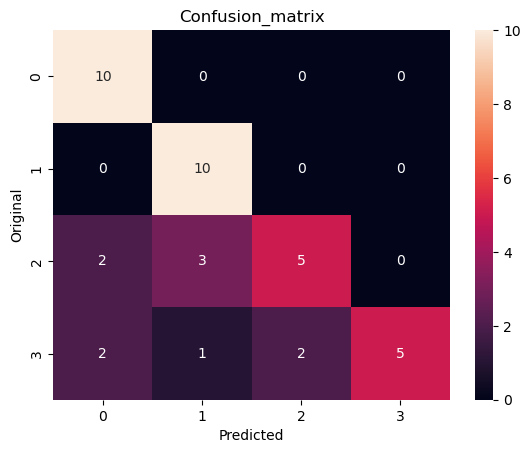

In [107]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')